In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt abbaia che poi ti arrestano la valigia

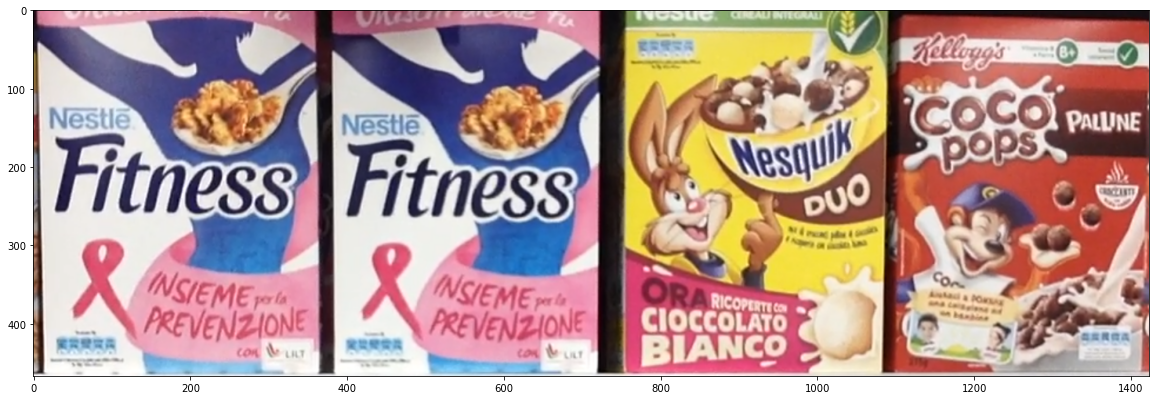

In [2]:
#Load Scene
scene_img = cv2.imread('./scenes/m1.png', cv2.COLOR_BGR2RGB)

#Plot Scene
plt.figure(figsize=(20, 10)) 
plt.imshow(cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB));

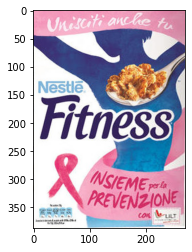

In [3]:
#Load Model
model_img = cv2.imread('./models/24.jpg', cv2.COLOR_BGR2RGB)

#Plot Model
plt.figure() 
plt.imshow(cv2.cvtColor(model_img, cv2.COLOR_BGR2RGB));

In [4]:
sift = cv2.xfeatures2d.SIFT_create()

In [5]:
model_img = cv2.cvtColor(model_img, cv2.COLOR_BGR2GRAY)
kp_model = sift.detect(model_img)

In [6]:
# Number of keypoints 
print(len(kp_model))

# Location of the keypoint
print(kp_model[0].pt)

# Scale
print(kp_model[0].size)

# Rotation
print(kp_model[0].angle)

1083
(2.4820573329925537, 62.448856353759766)
1.8934128284454346
129.18357849121094


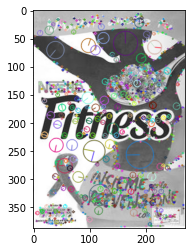

In [7]:
model_img_visualization = cv2.drawKeypoints(model_img, kp_model, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(model_img_visualization)
plt.show()

In [8]:
scene_img = cv2.cvtColor(scene_img, cv2.COLOR_BGR2GRAY)
kp_scene = sift.detect(scene_img)

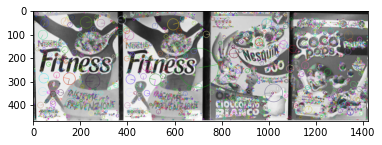

In [9]:
scene_img_visualization = cv2.drawKeypoints(scene_img,kp_scene,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(scene_img_visualization)
plt.show()

In [10]:
#Plot Scene
#plt.figure(figsize=(20, 10)) 
#plt.imshow(cv2.cvtColor(scene,cv2.COLOR_BGR2RGB))

In [11]:
kp_model, des_model = sift.compute(model_img, kp_model)
kp_scene, des_scene = sift.compute(scene_img, kp_scene)

In [12]:
print("Number of model descriptors: ", len(des_model))
print("Dimensionality of a SIFT descriptor: ", des_model[0].shape)
print("Type of the descriptor: ", des_model[0].dtype)

Number of model descriptors:  1083
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32


In [13]:
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 50)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching and finding the 2 closest elements for each query descriptor.
matches = flann.knnMatch(des_model, des_scene, k=2)

In [14]:
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance: #  if m.distance/n.distance < 0.7:
        good.append(m)

In [15]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    
    # building the corrspondences arrays of good matches
    src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Using RANSAC to estimate a robust homography. 
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Mask of discarded point used in visualization
    matchesMask = mask.ravel().tolist()
    
    # Corners of the query image
    h,w = model_img.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) # myc: these are the 4 corners of the query image
    
    # Projecting the corners into the train image
    dst = cv2.perspectiveTransform(pts,M) # myc: you project the corners by using the homography. M is the homography

    # Drawing the bounding box
    scene_img = cv2.polylines(scene_img, [np.int32(dst)],True, (0, 0, 255), 3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

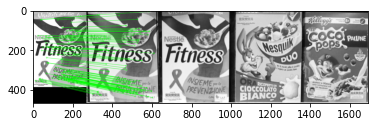

In [16]:
# Drawing the matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2) # not draw keypoints only lines
img3 = cv2.drawMatches(model_img, kp_model, scene_img, kp_scene, good, None, **draw_params)
plt.imshow(img3, 'gray')
plt.show()

In [19]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

src_pts_size = np.float32([ kp1[m.queryIdx].size for m in good ])
dst_pts_size = np.float32([ kp2[m.trainIdx].size for m in good ])

ratio_of_sizes = src_pts_size / dst_pts_size

Not enough matches are found - 0/10


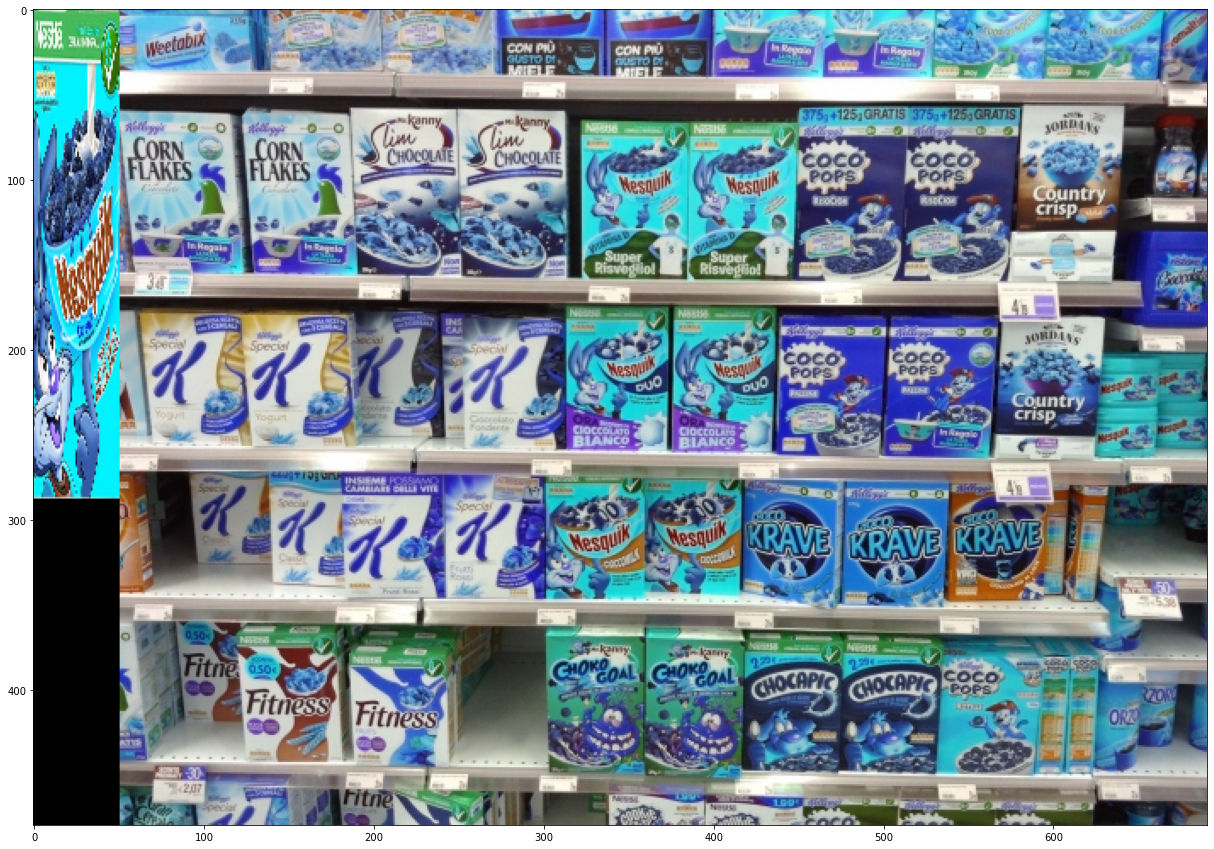

(<Figure size 2160x1080 with 1 Axes>,
 None)

In [18]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt
MIN_MATCH_COUNT = 10
img1 = cv2.imread('./models/5.jpg',cv2.COLOR_BGR2RGB) # queryImage
img2 = cv2.imread('./scenes/h1.jpg',cv2.COLOR_BGR2RGB) # trainImage
#percent by which the image is resized
scale_percent = 20
#calculate the 50 percent of original dimensions
width = int(img1.shape[1] * scale_percent / 100)
height = int(img2.shape[0] *3*scale_percent / 100)
# dsize
dsize = (width, height)
# resize image
img1 = cv2.resize(img1, dsize)

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create(nfeatures=5000)
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
        
        
        

        
        
        
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,d = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
    
    
    
    
    
    
    
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(30, 15)),plt.imshow(img3, 'gray'),plt.show()